# Segmentation of 4-channel competition data

This notebook, split into three sections, utilises cellpose to segment the 4-channel competition data using the h2b channels. 

- First section takes a single set of images and segments them.
- The second section is for bulk segmentation jobs over many images, many positions, many channels.
- The third and final section reorganises the output into different directories

In [1]:
import numpy as np
import time, os, sys, enum, glob
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io
from skimage.io import imread
from natsort import natsorted
from tqdm import tqdm
#from hurry.filesize import size
import tifffile as tiff

2021-08-18 17:52:13,371 [INFO] WRITING LOG OUTPUT TO /home/nathan/.cellpose/run.log


### Define channels available

In [3]:
@enum.unique
class channels(enum.Enum):
    bf = 0 
    gfp = 1
    rfp = 2
    irfp = 3
#     bf = 3 
#     gfp = 1
#     #rfp = 2
#     irfp = 2
#     masks = 3

## Split stacks

In [ ]:
## split stacks
position_list = ['Pos5']# ['Position1', 'Position2', 'Position3', 'Position4', 'Position5']
for position in position_list:
    #position = position[-1]
    data_folder = '/home/nathan/data/confocal/pcna/Position{}'.format(position)#'/media/nathan/Transcend/Nathan/data/pcna/test_210422/Pos7'
    output_dir = os.path.join(data_folder, 'single_tifs')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for channel in channels:
        #print(channel.name, 'splitting')
        file = glob.glob(os.path.join(data_folder,'Chan{}*.tif'.format(channel.value)))
        print(file)
        tif = np.array(tiff.imread(file),dtype=np.uint8)
        for frame in range(len(tif[:,0,0])):
            image = tif[frame,:,:]
            fn = 'img_channel00{}_position00{}_time{}_z000.tif'.format(channel.value, position, frame)
            with tiff.TiffWriter(os.path.join(output_dir,fn),imagej=True) as output_file:
                output_file.save(image)

In [ ]:
data_folder = '/home/nathan/data/MK0000_Pos5/Pos5/Pos5_stacks'#'/media/nathan/Transcend/Nathan/data/pcna/test_210422/Pos7'
output_dir = os.path.join('/home/nathan/data/MK0000_Pos5/Pos5', 'Pos5_raw')
position = 5
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for channel in channels:
    print(channel.name, 'splitting')
    file = glob.glob(os.path.join(data_folder,'channel00{}.tif'.format(channel.value)))
    print(file)
    tif = np.array(tiff.imread(file),dtype=np.uint8)
    for frame in range(len(tif[:,0,0])):
        image = tif[frame,:,:]
        fn = 'img_channel00{}_position00{}_time{}_z000.tif'.format(channel.value, position, frame)
        with tiff.TiffWriter(os.path.join(output_dir,fn),imagej=True) as output_file:
            output_file.save(image)

### Load images

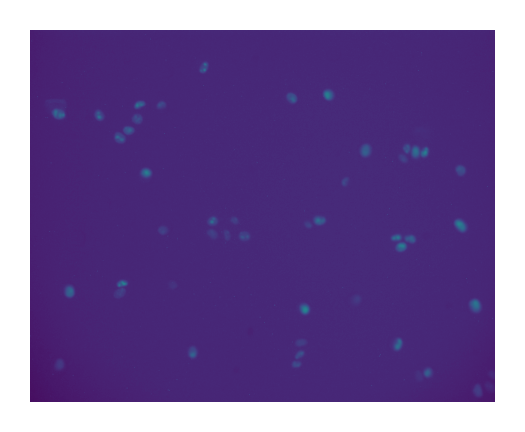

In [2]:
files = []
    
data_folder = '/home/nathan/data/MK0000_Pos5/Pos5/Pos5_raw_gpu'#'/home/nathan/data/confocal/pcna/Position1/single_tifs'#'/media/nathan/Transcend/Nathan/data/pcna/test_210422/Pos7'
# for channel in channelz:
#         files = glob.glob(os.path.join(data_folder,'img_channel00{}*.tif'.format(channel.value)))
## load just one channel
files = glob.glob(os.path.join(data_folder,'img_channel00{}*.tif'.format(3)))
files = natsorted(files)

# view 1 image
img = io.imread(files[1])#[-1])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

### Run cellpose on previously defined files 

In [4]:
# RUN CELLPOSE

from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='nuclei')

# define CHANNELS to run segementa0tion on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
#channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# imgs = [io.imread(filename) for filename in files]
# masks, flows, styles, diams = model.eval(imgs, diameter=50, channels=channels)
# io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# io.save_to_png(imgs, masks, flows, files)

# # or in a loop
#for chan, filename in zip(channels, files):
for filename in tqdm(files[0:2]):

    img = io.imread(filename)
    #masks, flows, styles, diams = model.eval(img, diameter=50, channels=chan)
    masks, flows, styles, diams = model.eval(img, diameter=None, channels=[0,0])

    # save results so you can load in gui
    #io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)
    #io.masks_flows_to_seg(img, masks, flows, diams, filename, [0,0])
    # save results as png
    io.save_to_png(img, masks, flows,filename)

2021-08-18 17:53:17,684 [INFO] ** TORCH CUDA version installed and working. **
2021-08-18 17:53:17,686 [INFO] >>>> using GPU


  0%|          | 0/2 [00:00<?, ?it/s]

2021-08-18 17:53:17,858 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/2 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.94 GiB total capacity; 841.80 MiB already allocated; 16.38 MiB free; 882.00 MiB reserved in total by PyTorch)

In [13]:
import torch
#torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  777303 KB |     768 MB |    1066 MB |  314902 KB |\n|       from large pool |  769856 KB |     761 MB |    1048 MB |  303809 KB |\n|       from small pool |    7447 KB |      14 MB |      18 MB |   11093 KB |\n|---------------------------------------------------------------------------|\n| Active memory         |  777303 KB |     768 MB |    1066 MB |  314902 KB |\n|       from large pool |  769856 KB |     761 MB |

In [15]:
import gc
del tif
gc.collect()

12899

In [1]:
import mxnet as mx

In [2]:
from cellpose import utils
use_GPU = utils.use_gpu()
print('GPU activated? %d'%use_GPU)

2021-08-18 17:30:39,812 [INFO] WRITING LOG OUTPUT TO /home/nathan/.cellpose/run.log


AttributeError: module 'cellpose.utils' has no attribute 'use_gpu'

In [31]:
utils.__file__

'/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/cellpose/utils.py'

# Running on cpu to test speed

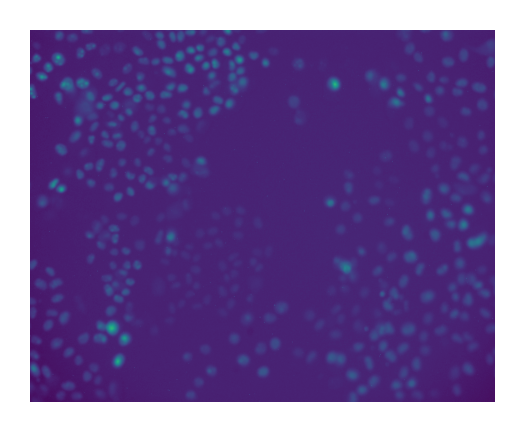

In [5]:
files = []
    
data_folder = '/home/nathan/data/MK0000_Pos5/Pos5/Pos5_raw_cpu'#'/home/nathan/data/confocal/pcna/Position1/single_tifs'#'/media/nathan/Transcend/Nathan/data/pcna/test_210422/Pos7'
# for channel in channelz:
#         files = glob.glob(os.path.join(data_folder,'img_channel00{}*.tif'.format(channel.value)))
## load just one channel
files = glob.glob(os.path.join(data_folder,'img_channel00{}*.tif'.format(3)))
files = natsorted(files)

# view 1 image
img = io.imread(files[-1])#[-1])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [25]:
# RUN CELLPOSE

from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='nuclei')

# define CHANNELS to run segementa0tion on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
#channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# imgs = [io.imread(filename) for filename in files]
# masks, flows, styles, diams = model.eval(imgs, diameter=50, channels=channels)
# io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# io.save_to_png(imgs, masks, flows, files)

# # or in a loop
#for chan, filename in zip(channels, files):
for filename in tqdm(files[0:10]):

    img = io.imread(filename)
    #masks, flows, styles, diams = model.eval(img, diameter=50, channels=chan)
    masks, flows, styles, diams = model.eval(img, diameter=None, channels=[0,0])

    # save results so you can load in gui
    #io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)
    #io.masks_flows_to_seg(img, masks, flows, diams, filename, [0,0])
    # save results as png
    io.save_to_png(img, masks, flows, filename)

2021-08-18 14:40:20,166 [INFO] >>>> using CPU


  0%|          | 0/10 [00:00<?, ?it/s]

2021-08-18 14:40:20,388 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-18 14:41:18,776 [INFO] estimated cell diameter(s) in 58.39 sec
2021-08-18 14:41:18,787 [INFO] >>> diameter(s) = 
2021-08-18 14:41:18,789 [INFO] [ 17.00 ]
2021-08-18 14:41:18,789 [INFO] ~~~ FINDING MASKS ~~~


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-18 14:42:00,886 [INFO] >>>> TOTAL TIME 100.50 sec


 10%|█         | 1/10 [01:41<15:10, 101.15s/it]

2021-08-18 14:42:01,430 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-18 14:42:50,234 [INFO] estimated cell diameter(s) in 48.80 sec
2021-08-18 14:42:50,236 [INFO] >>> diameter(s) = 
2021-08-18 14:42:50,237 [INFO] [ 3.45 ]
2021-08-18 14:42:50,237 [INFO] ~~~ FINDING MASKS ~~~
2021-08-18 14:55:08,207 [INFO] >>>> TOTAL TIME 786.78 sec


 20%|██        | 2/10 [14:48<1:07:16, 504.55s/it]

2021-08-18 14:55:08,341 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-18 14:55:56,228 [INFO] estimated cell diameter(s) in 47.89 sec
2021-08-18 14:55:56,228 [INFO] >>> diameter(s) = 
2021-08-18 14:55:56,229 [INFO] [ 17.00 ]
2021-08-18 14:55:56,229 [INFO] ~~~ FINDING MASKS ~~~


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-18 14:56:34,738 [INFO] >>>> TOTAL TIME 86.40 sec


 30%|███       | 3/10 [16:14<36:35, 313.64s/it]  

2021-08-18 14:56:35,511 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-18 14:57:22,885 [INFO] estimated cell diameter(s) in 47.37 sec
2021-08-18 14:57:22,886 [INFO] >>> diameter(s) = 
2021-08-18 14:57:22,887 [INFO] [ 17.00 ]
2021-08-18 14:57:22,887 [INFO] ~~~ FINDING MASKS ~~~


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-18 14:57:59,593 [INFO] >>>> TOTAL TIME 84.08 sec


 40%|████      | 4/10 [17:39<22:19, 223.31s/it]

2021-08-18 14:57:59,647 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-18 14:58:46,323 [INFO] estimated cell diameter(s) in 46.68 sec
2021-08-18 14:58:46,324 [INFO] >>> diameter(s) = 
2021-08-18 14:58:46,324 [INFO] [ 17.00 ]
2021-08-18 14:58:46,325 [INFO] ~~~ FINDING MASKS ~~~


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-18 14:59:22,814 [INFO] >>>> TOTAL TIME 83.17 sec


 50%|█████     | 5/10 [19:02<14:23, 172.80s/it]

2021-08-18 14:59:22,917 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-18 15:00:10,921 [INFO] estimated cell diameter(s) in 48.00 sec
2021-08-18 15:00:10,922 [INFO] >>> diameter(s) = 
2021-08-18 15:00:10,922 [INFO] [ 17.00 ]
2021-08-18 15:00:10,923 [INFO] ~~~ FINDING MASKS ~~~


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-18 15:00:47,677 [INFO] >>>> TOTAL TIME 84.76 sec


 60%|██████    | 6/10 [20:27<09:31, 142.91s/it]

2021-08-18 15:00:47,817 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-18 15:01:35,098 [INFO] estimated cell diameter(s) in 47.28 sec
2021-08-18 15:01:35,099 [INFO] >>> diameter(s) = 
2021-08-18 15:01:35,099 [INFO] [ 17.00 ]
2021-08-18 15:01:35,100 [INFO] ~~~ FINDING MASKS ~~~


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-18 15:02:09,996 [INFO] >>>> TOTAL TIME 82.18 sec


 70%|███████   | 7/10 [21:49<06:09, 123.10s/it]

2021-08-18 15:02:10,086 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-18 15:02:57,170 [INFO] estimated cell diameter(s) in 47.08 sec
2021-08-18 15:02:57,171 [INFO] >>> diameter(s) = 
2021-08-18 15:02:57,172 [INFO] [ 17.00 ]
2021-08-18 15:02:57,172 [INFO] ~~~ FINDING MASKS ~~~


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-18 15:03:31,792 [INFO] >>>> TOTAL TIME 81.71 sec


 80%|████████  | 8/10 [23:11<03:39, 109.94s/it]

2021-08-18 15:03:31,863 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-18 15:04:18,524 [INFO] estimated cell diameter(s) in 46.66 sec
2021-08-18 15:04:18,525 [INFO] >>> diameter(s) = 
2021-08-18 15:04:18,525 [INFO] [ 2.76 ]
2021-08-18 15:04:18,526 [INFO] ~~~ FINDING MASKS ~~~


 80%|████████  | 8/10 [43:31<10:52, 326.45s/it]


KeyboardInterrupt: 

### Show results of segmentation

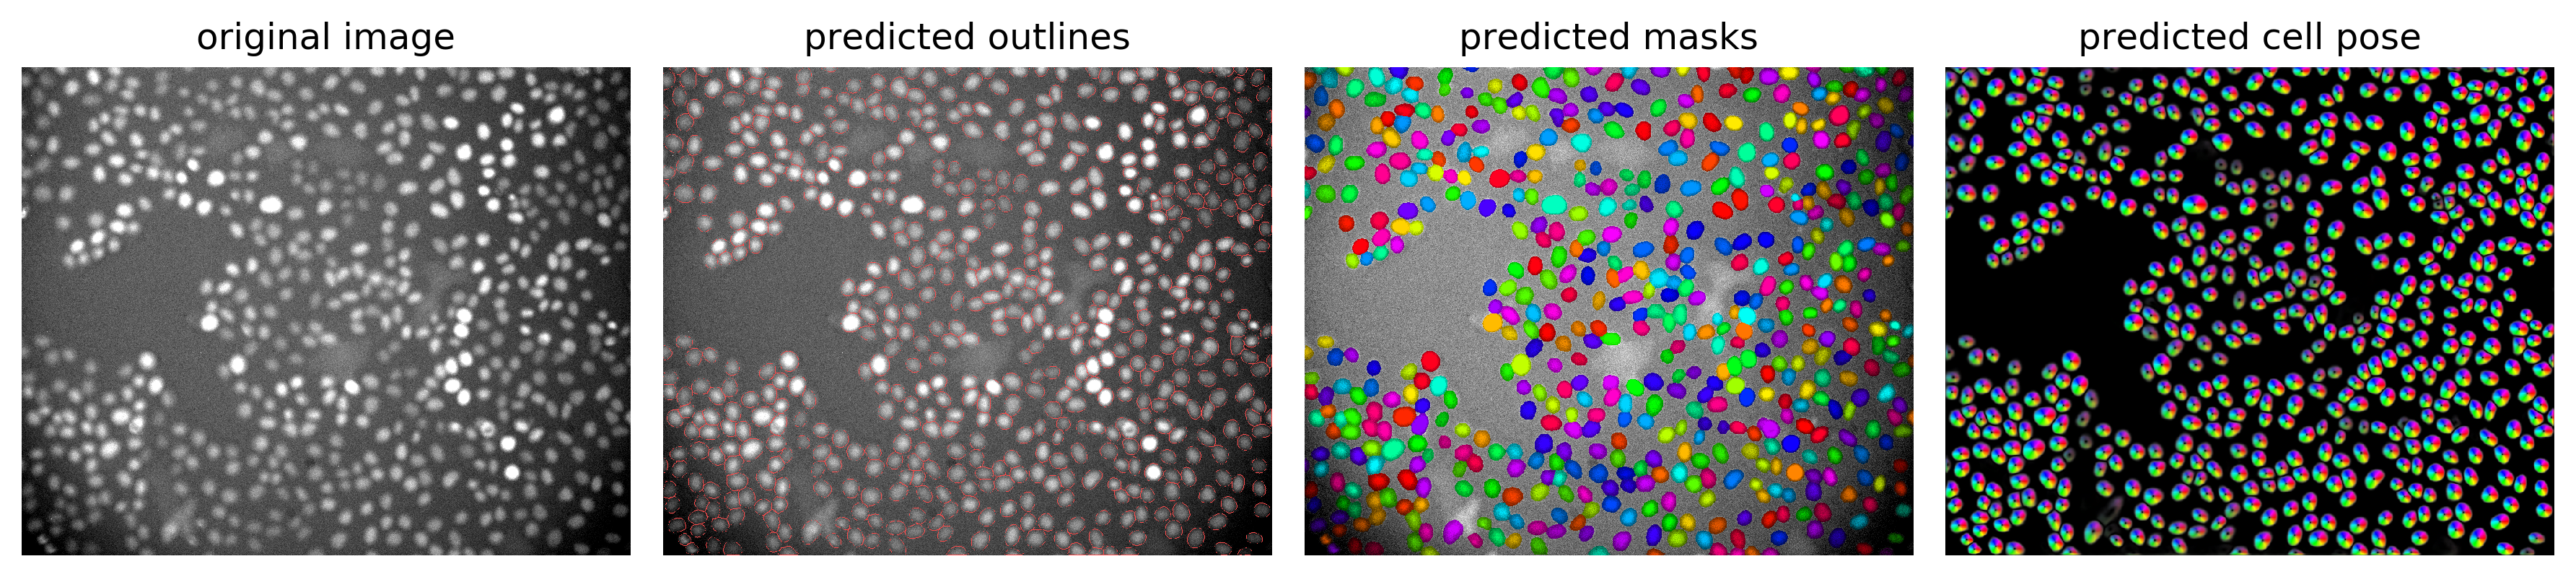

In [45]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=[0,0])
plt.tight_layout()
plt.show()

### Show larger image of segmentation

(-0.5, 1687.5, 1351.5, -0.5)

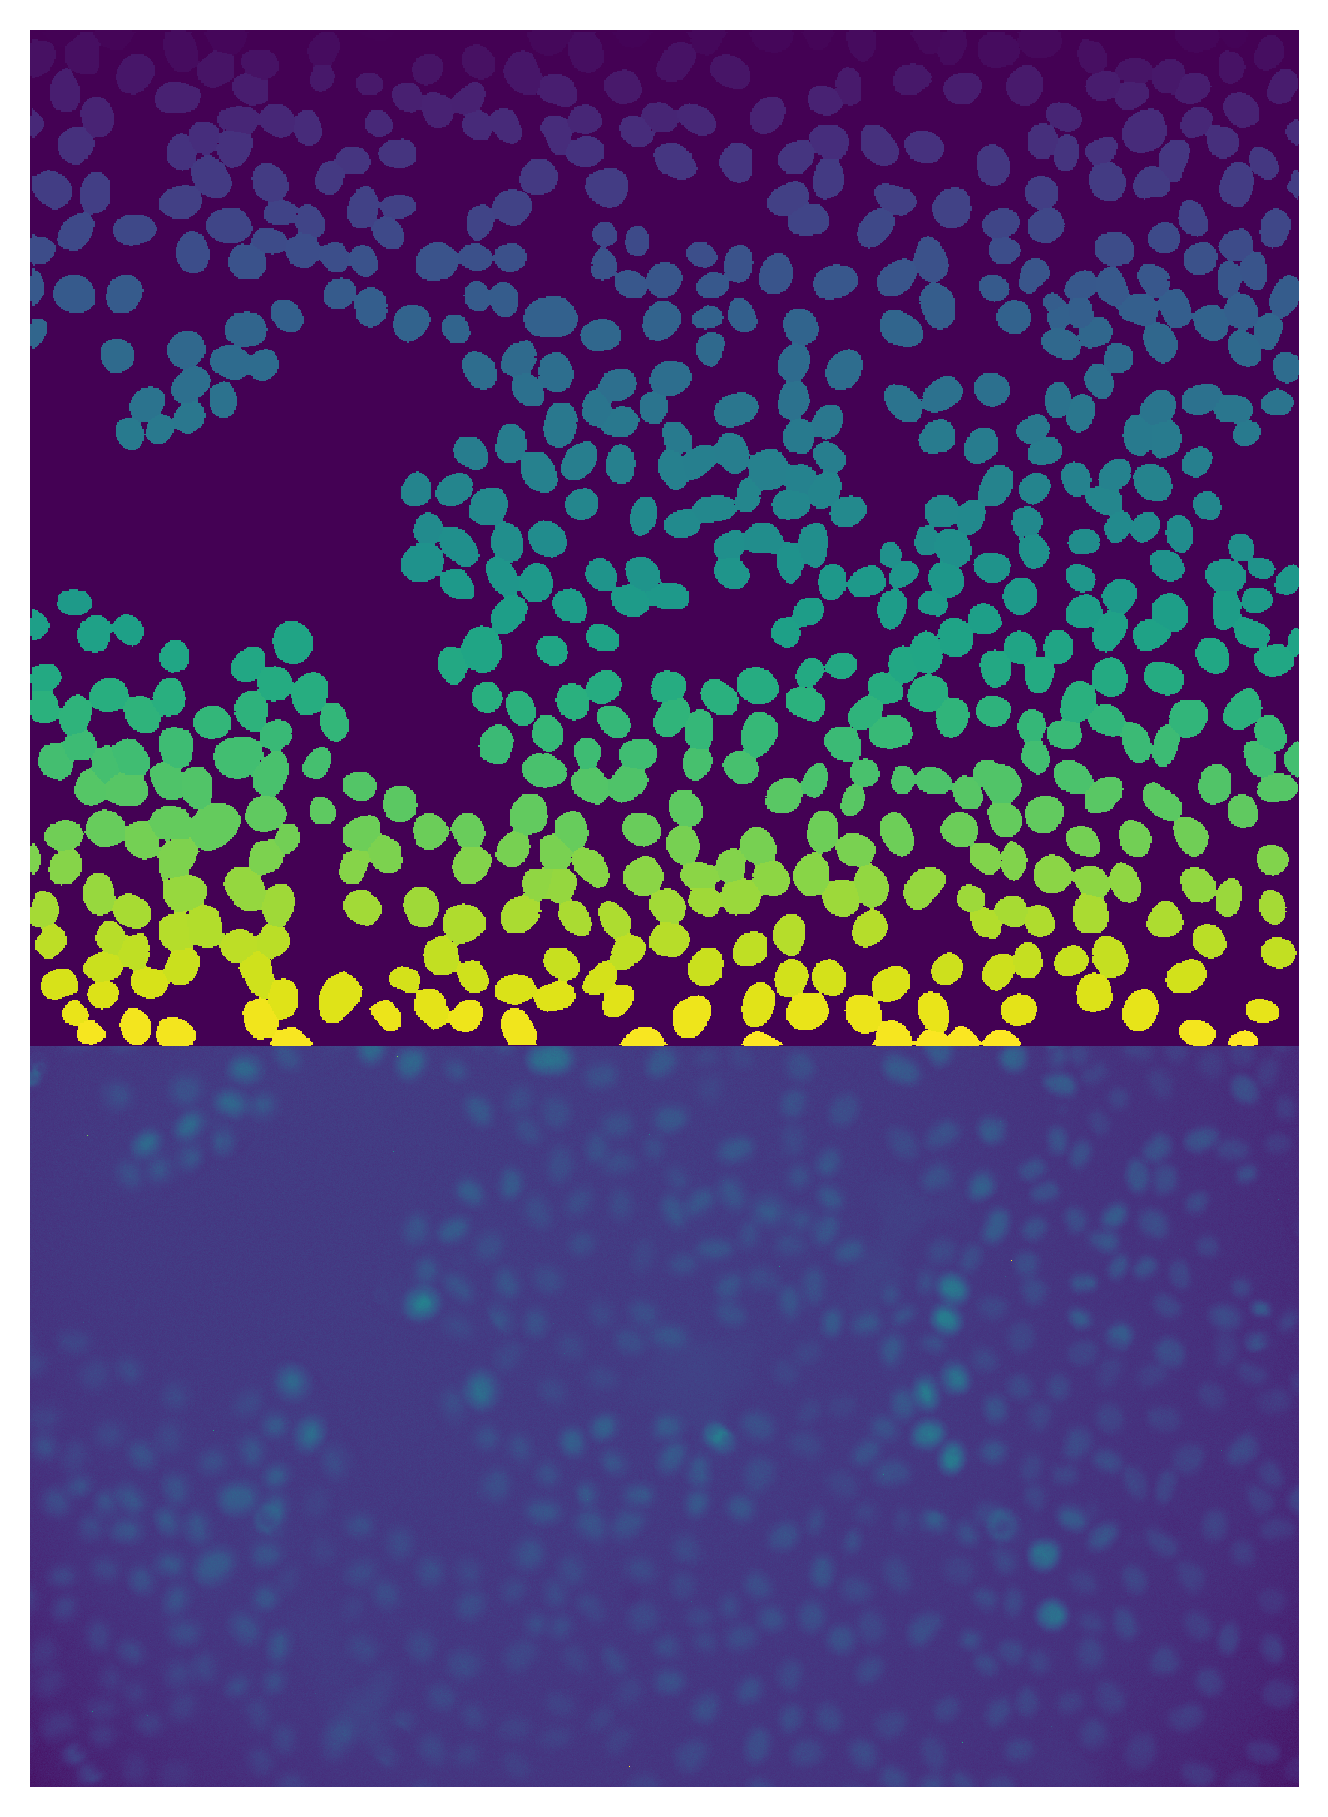

In [49]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,2)
ax1.imshow(img)
plt.axis('off')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(masks)
plt.axis('off')

# Bulk run segmentation job

Many positions, many channel, many frame

### Define channels and positions to be segmented

In [2]:
root_folder = '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/'#'/home/nathan/data/confocal/pcna'
expt = 'MK0000'

In [3]:
@enum.unique
class channelz(enum.Enum):
    #bf = 0 
    #gfp = 1
    #rfp = 2
    irfp = 3
pos_list = natsorted([pos for pos in os.listdir(os.path.join(root_folder, expt)) if 'Pos' in pos])
for pos in pos_list[:12]:
    print(pos)

Pos0
Pos1
Pos2
Pos3
Pos4
Pos5
Pos6
Pos7
Pos8
Pos9
Pos10
Pos11


In [ ]:
error_log = []
for expt in ['MK0000', 'MK0001']:
    for pos in tqdm(pos_list):
        data_folder = '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/{}/{}'.format(expt,pos)#'/home/nathan/data/confocal/pcna/Position{}'.format(pos)#
        files = []
        for channel in channelz:
                files = natsorted(glob.glob(os.path.join(data_folder,'{}_raw/img_channel00{}*.tif'.format(pos, channel.value))))

        # RUN CELLPOSE

                from cellpose import models, io

                # DEFINE CELLPOSE MODEL
                # model_type='cyto' or model_type='nuclei'
                model = models.Cellpose(gpu=False, model_type='cyto')

                # define CHANNELS to run segementa0tion on
                # grayscale=0, R=1, G=2, B=3
                # channels = [cytoplasm, nucleus]
                # if NUCLEUS channel does not exist, set the second channel to 0
                channels = [0,0]
                # IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
                # channels = [0,0] # IF YOU HAVE GRAYSCALE
                # channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
                # channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

                # or if you have different types of channels in each image
                #channels = [[2,3], [0,0], [0,0]]

                # if diameter is set to None, the size of the cells is estimated on a per image basis
                # you can set the average cell `diameter` in pixels yourself (recommended) 
                # diameter can be a list or a single number for all images

                # you can run all in a list e.g.
                # imgs = [io.imread(filename) for filename in files]
                # masks, flows, styles, diams = model.eval(imgs, diameter=50, channels=channels)
                # io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
                # io.save_to_png(imgs, masks, flows, files)

                # # or in a loop
                #for chan, filename in zip(channels, files):
                for filename in tqdm(files):
                    try:
                        ## check if mask already calculated
                        new_fn = filename.replace('.tif', '_cp_masks.png')
                        if os.path.exists(new_fn):
                            print(filename, 'skipped as already made')
                            continue
                        img = io.imread(filename)
                        #masks, flows, styles, diams = model.eval(img, diameter=50, channels=chan)
                        masks, flows, styles, diams = model.eval(img, diameter=None, channels=[0,0])

                        # save results so you can load in gui
                        #io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)
                        #### DO NOT NEED THE FOLLOWING LINE
                        #io.masks_flows_to_seg(img, masks, flows, diams, filename, [0,0])

                        # save results as png
                        io.save_to_png(img, masks, 0, filename)
                    except:
                        error_message = filename + 'failed to process'
                        error_log.append(error_message)

2021-08-16 14:45:29,330 [INFO] >>>> TOTAL TIME 94.08 sec



 85%|██████████████████████████████████████████████████         | 861/1014 [17:04:07<3:59:14, 93.82s/it]

2021-08-16 14:45:29,495 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 14:46:14,703 [INFO] estimated cell diameter(s) in 45.21 sec
2021-08-16 14:46:14,704 [INFO] >>> diameter(s) = 
2021-08-16 14:46:14,705 [INFO] [ 30.66 ]
2021-08-16 14:46:14,705 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 14:47:03,109 [INFO] >>>> TOTAL TIME 93.61 sec



 85%|██████████████████████████████████████████████████▏        | 862/1014 [17:05:40<3:57:39, 93.81s/it]

2021-08-16 14:47:03,312 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 14:47:48,168 [INFO] estimated cell diameter(s) in 44.86 sec
2021-08-16 14:47:48,169 [INFO] >>> diameter(s) = 
2021-08-16 14:47:48,169 [INFO] [ 30.96 ]
2021-08-16 14:47:48,170 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 14:48:36,865 [INFO] >>>> TOTAL TIME 93.55 sec



 85%|██████████████████████████████████████████████████▏        | 863/1014 [17:07:14<3:56:02, 93.79s/it]

2021-08-16 14:48:37,061 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 14:49:21,533 [INFO] estimated cell diameter(s) in 44.47 sec
2021-08-16 14:49:21,534 [INFO] >>> diameter(s) = 
2021-08-16 14:49:21,535 [INFO] [ 30.98 ]
2021-08-16 14:49:21,535 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 14:50:10,013 [INFO] >>>> TOTAL TIME 92.95 sec



 85%|██████████████████████████████████████████████████▎        | 864/1014 [17:08:47<3:54:00, 93.60s/it]

2021-08-16 14:50:10,195 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 14:50:55,204 [INFO] estimated cell diameter(s) in 45.01 sec
2021-08-16 14:50:55,205 [INFO] >>> diameter(s) = 
2021-08-16 14:50:55,206 [INFO] [ 30.93 ]
2021-08-16 14:50:55,206 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 14:51:43,992 [INFO] >>>> TOTAL TIME 93.80 sec



 85%|██████████████████████████████████████████████████▎        | 865/1014 [17:10:21<3:52:46, 93.74s/it]

2021-08-16 14:51:44,269 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 14:52:28,855 [INFO] estimated cell diameter(s) in 44.59 sec
2021-08-16 14:52:28,856 [INFO] >>> diameter(s) = 
2021-08-16 14:52:28,857 [INFO] [ 30.96 ]
2021-08-16 14:52:28,858 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 14:53:17,167 [INFO] >>>> TOTAL TIME 92.90 sec



 85%|██████████████████████████████████████████████████▍        | 866/1014 [17:11:55<3:50:46, 93.56s/it]

2021-08-16 14:53:17,466 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 14:54:08,383 [INFO] estimated cell diameter(s) in 50.92 sec
2021-08-16 14:54:08,384 [INFO] >>> diameter(s) = 
2021-08-16 14:54:08,384 [INFO] [ 30.80 ]
2021-08-16 14:54:08,385 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 14:54:59,126 [INFO] >>>> TOTAL TIME 101.66 sec



 86%|██████████████████████████████████████████████████▍        | 867/1014 [17:13:36<3:55:21, 96.06s/it]

2021-08-16 14:54:59,565 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 14:55:46,462 [INFO] estimated cell diameter(s) in 46.90 sec
2021-08-16 14:55:46,463 [INFO] >>> diameter(s) = 
2021-08-16 14:55:46,464 [INFO] [ 31.17 ]
2021-08-16 14:55:46,465 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 14:56:36,791 [INFO] >>>> TOTAL TIME 97.23 sec



 86%|██████████████████████████████████████████████████▌        | 868/1014 [17:15:14<3:54:55, 96.54s/it]

2021-08-16 14:56:36,978 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 14:57:25,279 [INFO] estimated cell diameter(s) in 48.30 sec
2021-08-16 14:57:25,281 [INFO] >>> diameter(s) = 
2021-08-16 14:57:25,281 [INFO] [ 30.90 ]
2021-08-16 14:57:25,282 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 14:58:16,316 [INFO] >>>> TOTAL TIME 99.34 sec



 86%|██████████████████████████████████████████████████▌        | 869/1014 [17:16:54<3:55:31, 97.46s/it]

2021-08-16 14:58:16,595 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 14:59:03,163 [INFO] estimated cell diameter(s) in 46.57 sec
2021-08-16 14:59:03,165 [INFO] >>> diameter(s) = 
2021-08-16 14:59:03,165 [INFO] [ 30.82 ]
2021-08-16 14:59:03,165 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 14:59:52,445 [INFO] >>>> TOTAL TIME 95.85 sec



 86%|██████████████████████████████████████████████████▌        | 870/1014 [17:18:30<3:52:57, 97.07s/it]

2021-08-16 14:59:52,784 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:00:38,545 [INFO] estimated cell diameter(s) in 45.76 sec
2021-08-16 15:00:38,546 [INFO] >>> diameter(s) = 
2021-08-16 15:00:38,547 [INFO] [ 30.86 ]
2021-08-16 15:00:38,547 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:01:28,080 [INFO] >>>> TOTAL TIME 95.30 sec



 86%|██████████████████████████████████████████████████▋        | 871/1014 [17:20:05<3:50:17, 96.62s/it]

2021-08-16 15:01:28,341 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:02:13,403 [INFO] estimated cell diameter(s) in 45.06 sec
2021-08-16 15:02:13,404 [INFO] >>> diameter(s) = 
2021-08-16 15:02:13,405 [INFO] [ 31.05 ]
2021-08-16 15:02:13,406 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:03:02,965 [INFO] >>>> TOTAL TIME 94.62 sec



 86%|██████████████████████████████████████████████████▋        | 872/1014 [17:21:40<3:47:26, 96.10s/it]

2021-08-16 15:03:03,226 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:03:48,356 [INFO] estimated cell diameter(s) in 45.13 sec
2021-08-16 15:03:48,357 [INFO] >>> diameter(s) = 
2021-08-16 15:03:48,358 [INFO] [ 30.78 ]
2021-08-16 15:03:48,359 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:04:37,583 [INFO] >>>> TOTAL TIME 94.36 sec



 86%|██████████████████████████████████████████████████▊        | 873/1014 [17:23:15<3:44:48, 95.66s/it]

2021-08-16 15:04:37,848 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:05:23,117 [INFO] estimated cell diameter(s) in 45.27 sec
2021-08-16 15:05:23,118 [INFO] >>> diameter(s) = 
2021-08-16 15:05:23,119 [INFO] [ 30.78 ]
2021-08-16 15:05:23,119 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:06:13,073 [INFO] >>>> TOTAL TIME 95.22 sec



 86%|██████████████████████████████████████████████████▊        | 874/1014 [17:24:50<3:43:05, 95.61s/it]

2021-08-16 15:06:13,368 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:06:58,840 [INFO] estimated cell diameter(s) in 45.47 sec
2021-08-16 15:06:58,841 [INFO] >>> diameter(s) = 
2021-08-16 15:06:58,842 [INFO] [ 30.92 ]
2021-08-16 15:06:58,843 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:07:47,504 [INFO] >>>> TOTAL TIME 94.14 sec



 86%|██████████████████████████████████████████████████▉        | 875/1014 [17:26:25<3:40:38, 95.24s/it]

2021-08-16 15:07:47,680 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:08:14,137 [INFO] estimated cell diameter(s) in 26.46 sec
2021-08-16 15:08:14,138 [INFO] >>> diameter(s) = 
2021-08-16 15:08:14,139 [INFO] [ 30.00 ]
2021-08-16 15:08:14,140 [INFO] ~~~ FINDING MASKS ~~~


/home/nathan/anaconda3/envs/cell-comp-analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nathan/anaconda3/envs/cell-comp-analysis/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-16 15:09:01,068 [INFO] >>>> TOTAL TIME 73.39 sec



 86%|██████████████████████████████████████████████████▉        | 876/1014 [17:27:38<3:24:04, 88.73s/it]

2021-08-16 15:09:01,320 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:09:49,664 [INFO] estimated cell diameter(s) in 48.34 sec
2021-08-16 15:09:49,665 [INFO] >>> diameter(s) = 
2021-08-16 15:09:49,666 [INFO] [ 30.61 ]
2021-08-16 15:09:49,667 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:10:40,045 [INFO] >>>> TOTAL TIME 98.72 sec



 86%|███████████████████████████████████████████████████        | 877/1014 [17:29:17<3:29:36, 91.80s/it]

2021-08-16 15:10:40,215 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:11:27,721 [INFO] estimated cell diameter(s) in 47.51 sec
2021-08-16 15:11:27,722 [INFO] >>> diameter(s) = 
2021-08-16 15:11:27,723 [INFO] [ 30.88 ]
2021-08-16 15:11:27,725 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:12:19,542 [INFO] >>>> TOTAL TIME 99.33 sec



 87%|███████████████████████████████████████████████████        | 878/1014 [17:30:57<3:33:28, 94.18s/it]

2021-08-16 15:12:19,999 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:13:06,854 [INFO] estimated cell diameter(s) in 46.85 sec
2021-08-16 15:13:06,855 [INFO] >>> diameter(s) = 
2021-08-16 15:13:06,856 [INFO] [ 30.67 ]
2021-08-16 15:13:06,856 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:13:54,482 [INFO] >>>> TOTAL TIME 94.48 sec



 87%|███████████████████████████████████████████████████▏       | 879/1014 [17:32:32<3:32:22, 94.39s/it]

2021-08-16 15:13:55,004 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:14:43,371 [INFO] estimated cell diameter(s) in 48.37 sec
2021-08-16 15:14:43,372 [INFO] >>> diameter(s) = 
2021-08-16 15:14:43,372 [INFO] [ 30.70 ]
2021-08-16 15:14:43,373 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:15:32,390 [INFO] >>>> TOTAL TIME 97.39 sec



 87%|███████████████████████████████████████████████████▏       | 880/1014 [17:34:10<3:33:10, 95.45s/it]

2021-08-16 15:15:32,802 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:16:17,710 [INFO] estimated cell diameter(s) in 44.91 sec
2021-08-16 15:16:17,711 [INFO] >>> diameter(s) = 
2021-08-16 15:16:17,712 [INFO] [ 30.80 ]
2021-08-16 15:16:17,712 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:17:08,242 [INFO] >>>> TOTAL TIME 95.44 sec



 87%|███████████████████████████████████████████████████▎       | 881/1014 [17:35:46<3:31:55, 95.60s/it]

2021-08-16 15:17:08,835 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:17:54,980 [INFO] estimated cell diameter(s) in 46.15 sec
2021-08-16 15:17:54,981 [INFO] >>> diameter(s) = 
2021-08-16 15:17:54,982 [INFO] [ 30.92 ]
2021-08-16 15:17:54,984 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:18:45,166 [INFO] >>>> TOTAL TIME 96.33 sec



 87%|███████████████████████████████████████████████████▎       | 882/1014 [17:37:23<3:31:07, 95.97s/it]

2021-08-16 15:18:45,648 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:19:34,303 [INFO] estimated cell diameter(s) in 48.66 sec
2021-08-16 15:19:34,304 [INFO] >>> diameter(s) = 
2021-08-16 15:19:34,305 [INFO] [ 30.92 ]
2021-08-16 15:19:34,306 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:20:23,095 [INFO] >>>> TOTAL TIME 97.45 sec



 87%|███████████████████████████████████████████████████▍       | 883/1014 [17:39:01<3:30:47, 96.55s/it]

2021-08-16 15:20:23,461 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:21:08,910 [INFO] estimated cell diameter(s) in 45.45 sec
2021-08-16 15:21:08,911 [INFO] >>> diameter(s) = 
2021-08-16 15:21:08,911 [INFO] [ 30.92 ]
2021-08-16 15:21:08,912 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:21:57,947 [INFO] >>>> TOTAL TIME 94.49 sec



 87%|███████████████████████████████████████████████████▍       | 884/1014 [17:40:35<3:28:06, 96.05s/it]

2021-08-16 15:21:58,377 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:22:43,056 [INFO] estimated cell diameter(s) in 44.68 sec
2021-08-16 15:22:43,057 [INFO] >>> diameter(s) = 
2021-08-16 15:22:43,058 [INFO] [ 31.00 ]
2021-08-16 15:22:43,058 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:23:32,598 [INFO] >>>> TOTAL TIME 94.22 sec



 87%|███████████████████████████████████████████████████▍       | 885/1014 [17:42:10<3:25:34, 95.62s/it]

2021-08-16 15:23:32,987 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:24:20,668 [INFO] estimated cell diameter(s) in 47.68 sec
2021-08-16 15:24:20,669 [INFO] >>> diameter(s) = 
2021-08-16 15:24:20,669 [INFO] [ 30.70 ]
2021-08-16 15:24:20,670 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:25:09,951 [INFO] >>>> TOTAL TIME 96.96 sec



 87%|███████████████████████████████████████████████████▌       | 886/1014 [17:43:47<3:25:02, 96.11s/it]

2021-08-16 15:25:10,206 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:25:56,905 [INFO] estimated cell diameter(s) in 46.70 sec
2021-08-16 15:25:56,906 [INFO] >>> diameter(s) = 
2021-08-16 15:25:56,907 [INFO] [ 31.00 ]
2021-08-16 15:25:56,908 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:26:47,586 [INFO] >>>> TOTAL TIME 97.38 sec



 87%|███████████████████████████████████████████████████▌       | 887/1014 [17:45:25<3:24:23, 96.56s/it]

2021-08-16 15:26:47,788 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:27:35,614 [INFO] estimated cell diameter(s) in 47.83 sec
2021-08-16 15:27:35,615 [INFO] >>> diameter(s) = 
2021-08-16 15:27:35,615 [INFO] [ 30.78 ]
2021-08-16 15:27:35,616 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:28:25,021 [INFO] >>>> TOTAL TIME 97.23 sec



 88%|███████████████████████████████████████████████████▋       | 888/1014 [17:47:02<3:23:19, 96.82s/it]

2021-08-16 15:28:25,221 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:29:11,207 [INFO] estimated cell diameter(s) in 45.99 sec
2021-08-16 15:29:11,208 [INFO] >>> diameter(s) = 
2021-08-16 15:29:11,209 [INFO] [ 30.94 ]
2021-08-16 15:29:11,209 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:30:00,765 [INFO] >>>> TOTAL TIME 95.54 sec



 88%|███████████████████████████████████████████████████▋       | 889/1014 [17:48:38<3:21:02, 96.50s/it]

2021-08-16 15:30:01,030 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:30:46,328 [INFO] estimated cell diameter(s) in 45.30 sec
2021-08-16 15:30:46,329 [INFO] >>> diameter(s) = 
2021-08-16 15:30:46,329 [INFO] [ 31.00 ]
2021-08-16 15:30:46,330 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:31:35,271 [INFO] >>>> TOTAL TIME 94.24 sec



 88%|███████████████████████████████████████████████████▊       | 890/1014 [17:50:13<3:18:18, 95.96s/it]

2021-08-16 15:31:35,774 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:32:22,345 [INFO] estimated cell diameter(s) in 46.57 sec
2021-08-16 15:32:22,347 [INFO] >>> diameter(s) = 
2021-08-16 15:32:22,349 [INFO] [ 30.93 ]
2021-08-16 15:32:22,349 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:33:10,885 [INFO] >>>> TOTAL TIME 95.11 sec



 88%|███████████████████████████████████████████████████▊       | 891/1014 [17:51:48<3:16:24, 95.81s/it]

2021-08-16 15:33:11,138 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:33:56,563 [INFO] estimated cell diameter(s) in 45.42 sec
2021-08-16 15:33:56,564 [INFO] >>> diameter(s) = 
2021-08-16 15:33:56,565 [INFO] [ 30.88 ]
2021-08-16 15:33:56,565 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:34:45,859 [INFO] >>>> TOTAL TIME 94.72 sec



 88%|███████████████████████████████████████████████████▉       | 892/1014 [17:53:23<3:14:20, 95.57s/it]

2021-08-16 15:34:46,166 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:35:32,169 [INFO] estimated cell diameter(s) in 46.00 sec
2021-08-16 15:35:32,170 [INFO] >>> diameter(s) = 
2021-08-16 15:35:32,171 [INFO] [ 30.90 ]
2021-08-16 15:35:32,172 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:36:20,421 [INFO] >>>> TOTAL TIME 94.26 sec



 88%|███████████████████████████████████████████████████▉       | 893/1014 [17:54:58<3:12:10, 95.29s/it]

2021-08-16 15:36:20,820 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:37:06,488 [INFO] estimated cell diameter(s) in 45.67 sec
2021-08-16 15:37:06,489 [INFO] >>> diameter(s) = 
2021-08-16 15:37:06,490 [INFO] [ 31.05 ]
2021-08-16 15:37:06,490 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:37:55,283 [INFO] >>>> TOTAL TIME 94.46 sec



 88%|████████████████████████████████████████████████████       | 894/1014 [17:56:33<3:10:20, 95.17s/it]

2021-08-16 15:37:55,699 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:38:43,185 [INFO] estimated cell diameter(s) in 47.49 sec
2021-08-16 15:38:43,186 [INFO] >>> diameter(s) = 
2021-08-16 15:38:43,186 [INFO] [ 30.58 ]
2021-08-16 15:38:43,187 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:39:31,774 [INFO] >>>> TOTAL TIME 96.08 sec



 88%|████████████████████████████████████████████████████       | 895/1014 [17:58:09<3:09:26, 95.52s/it]

2021-08-16 15:39:32,043 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:40:19,604 [INFO] estimated cell diameter(s) in 47.56 sec
2021-08-16 15:40:19,605 [INFO] >>> diameter(s) = 
2021-08-16 15:40:19,606 [INFO] [ 30.57 ]
2021-08-16 15:40:19,606 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:41:06,715 [INFO] >>>> TOTAL TIME 94.67 sec



 88%|████████████████████████████████████████████████████▏      | 896/1014 [17:59:44<3:07:31, 95.35s/it]

2021-08-16 15:41:07,009 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:41:52,245 [INFO] estimated cell diameter(s) in 45.24 sec
2021-08-16 15:41:52,246 [INFO] >>> diameter(s) = 
2021-08-16 15:41:52,247 [INFO] [ 30.59 ]
2021-08-16 15:41:52,247 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:42:39,519 [INFO] >>>> TOTAL TIME 92.51 sec



 88%|████████████████████████████████████████████████████▏      | 897/1014 [18:01:17<3:04:26, 94.58s/it]

2021-08-16 15:42:39,798 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:43:25,208 [INFO] estimated cell diameter(s) in 45.41 sec
2021-08-16 15:43:25,209 [INFO] >>> diameter(s) = 
2021-08-16 15:43:25,210 [INFO] [ 30.53 ]
2021-08-16 15:43:25,211 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:44:14,048 [INFO] >>>> TOTAL TIME 94.25 sec



 89%|████████████████████████████████████████████████████▎      | 898/1014 [18:02:51<3:02:49, 94.56s/it]

2021-08-16 15:44:14,282 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:44:58,784 [INFO] estimated cell diameter(s) in 44.50 sec
2021-08-16 15:44:58,785 [INFO] >>> diameter(s) = 
2021-08-16 15:44:58,786 [INFO] [ 30.67 ]
2021-08-16 15:44:58,787 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:45:47,735 [INFO] >>>> TOTAL TIME 93.45 sec



 89%|████████████████████████████████████████████████████▎      | 899/1014 [18:04:25<3:00:45, 94.30s/it]

2021-08-16 15:45:47,980 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:46:32,280 [INFO] estimated cell diameter(s) in 44.30 sec
2021-08-16 15:46:32,281 [INFO] >>> diameter(s) = 
2021-08-16 15:46:32,281 [INFO] [ 30.52 ]
2021-08-16 15:46:32,282 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:47:21,882 [INFO] >>>> TOTAL TIME 93.90 sec



 89%|████████████████████████████████████████████████████▎      | 900/1014 [18:05:59<2:59:04, 94.25s/it]

2021-08-16 15:47:22,121 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:48:07,442 [INFO] estimated cell diameter(s) in 45.32 sec
2021-08-16 15:48:07,443 [INFO] >>> diameter(s) = 
2021-08-16 15:48:07,443 [INFO] [ 30.70 ]
2021-08-16 15:48:07,444 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:48:55,602 [INFO] >>>> TOTAL TIME 93.48 sec



 89%|████████████████████████████████████████████████████▍      | 901/1014 [18:07:33<2:57:12, 94.09s/it]

2021-08-16 15:48:55,853 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:49:36,666 [INFO] estimated cell diameter(s) in 40.81 sec
2021-08-16 15:49:36,667 [INFO] >>> diameter(s) = 
2021-08-16 15:49:36,667 [INFO] [ 29.16 ]
2021-08-16 15:49:36,668 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:50:28,707 [INFO] >>>> TOTAL TIME 92.85 sec



 89%|████████████████████████████████████████████████████▍      | 902/1014 [18:09:06<2:55:05, 93.80s/it]

2021-08-16 15:50:28,943 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:51:15,681 [INFO] estimated cell diameter(s) in 46.74 sec
2021-08-16 15:51:15,682 [INFO] >>> diameter(s) = 
2021-08-16 15:51:15,682 [INFO] [ 30.72 ]
2021-08-16 15:51:15,683 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:52:03,585 [INFO] >>>> TOTAL TIME 94.64 sec



 89%|████████████████████████████████████████████████████▌      | 903/1014 [18:10:41<2:54:10, 94.15s/it]

2021-08-16 15:52:03,998 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:52:50,589 [INFO] estimated cell diameter(s) in 46.59 sec
2021-08-16 15:52:50,590 [INFO] >>> diameter(s) = 
2021-08-16 15:52:50,591 [INFO] [ 30.40 ]
2021-08-16 15:52:50,591 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:53:43,068 [INFO] >>>> TOTAL TIME 99.07 sec



 89%|████████████████████████████████████████████████████▌      | 904/1014 [18:12:20<2:55:28, 95.72s/it]

2021-08-16 15:53:43,302 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:54:27,998 [INFO] estimated cell diameter(s) in 44.70 sec
2021-08-16 15:54:27,999 [INFO] >>> diameter(s) = 
2021-08-16 15:54:27,999 [INFO] [ 30.78 ]
2021-08-16 15:54:27,999 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:55:17,103 [INFO] >>>> TOTAL TIME 93.80 sec



 89%|████████████████████████████████████████████████████▋      | 905/1014 [18:13:55<2:53:01, 95.24s/it]

2021-08-16 15:55:17,544 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:56:02,459 [INFO] estimated cell diameter(s) in 44.91 sec
2021-08-16 15:56:02,460 [INFO] >>> diameter(s) = 
2021-08-16 15:56:02,461 [INFO] [ 30.65 ]
2021-08-16 15:56:02,461 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:56:51,078 [INFO] >>>> TOTAL TIME 93.53 sec



 89%|████████████████████████████████████████████████████▋      | 906/1014 [18:15:28<2:50:43, 94.85s/it]

2021-08-16 15:56:51,366 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:57:35,619 [INFO] estimated cell diameter(s) in 44.25 sec
2021-08-16 15:57:35,619 [INFO] >>> diameter(s) = 
2021-08-16 15:57:35,620 [INFO] [ 30.76 ]
2021-08-16 15:57:35,620 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 15:58:24,235 [INFO] >>>> TOTAL TIME 92.87 sec



 89%|████████████████████████████████████████████████████▊      | 907/1014 [18:17:02<2:48:15, 94.35s/it]

2021-08-16 15:58:24,611 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 15:59:11,989 [INFO] estimated cell diameter(s) in 47.38 sec
2021-08-16 15:59:11,990 [INFO] >>> diameter(s) = 
2021-08-16 15:59:11,991 [INFO] [ 30.70 ]
2021-08-16 15:59:11,992 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:00:01,242 [INFO] >>>> TOTAL TIME 96.63 sec



 90%|████████████████████████████████████████████████████▊      | 908/1014 [18:18:39<2:48:02, 95.12s/it]

2021-08-16 16:00:01,419 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:00:48,743 [INFO] estimated cell diameter(s) in 47.32 sec
2021-08-16 16:00:48,744 [INFO] >>> diameter(s) = 
2021-08-16 16:00:48,744 [INFO] [ 30.32 ]
2021-08-16 16:00:48,745 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:01:42,071 [INFO] >>>> TOTAL TIME 100.65 sec



 90%|████████████████████████████████████████████████████▉      | 909/1014 [18:20:19<2:49:27, 96.83s/it]

2021-08-16 16:01:42,275 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:02:29,264 [INFO] estimated cell diameter(s) in 46.99 sec
2021-08-16 16:02:29,265 [INFO] >>> diameter(s) = 
2021-08-16 16:02:29,265 [INFO] [ 30.55 ]
2021-08-16 16:02:29,265 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:03:17,810 [INFO] >>>> TOTAL TIME 95.53 sec



 90%|████████████████████████████████████████████████████▉      | 910/1014 [18:21:55<2:47:16, 96.50s/it]

2021-08-16 16:03:18,013 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:04:05,424 [INFO] estimated cell diameter(s) in 47.41 sec
2021-08-16 16:04:05,425 [INFO] >>> diameter(s) = 
2021-08-16 16:04:05,425 [INFO] [ 30.32 ]
2021-08-16 16:04:05,426 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:04:59,117 [INFO] >>>> TOTAL TIME 101.10 sec



 90%|█████████████████████████████████████████████████████      | 911/1014 [18:23:37<2:48:11, 97.98s/it]

2021-08-16 16:04:59,471 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:05:47,081 [INFO] estimated cell diameter(s) in 47.61 sec
2021-08-16 16:05:47,082 [INFO] >>> diameter(s) = 
2021-08-16 16:05:47,083 [INFO] [ 30.42 ]
2021-08-16 16:05:47,083 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:06:36,495 [INFO] >>>> TOTAL TIME 97.02 sec



 90%|█████████████████████████████████████████████████████      | 912/1014 [18:25:14<2:46:14, 97.79s/it]

2021-08-16 16:06:36,835 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:07:24,512 [INFO] estimated cell diameter(s) in 47.68 sec
2021-08-16 16:07:24,512 [INFO] >>> diameter(s) = 
2021-08-16 16:07:24,513 [INFO] [ 30.36 ]
2021-08-16 16:07:24,514 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:08:18,445 [INFO] >>>> TOTAL TIME 101.61 sec



 90%|█████████████████████████████████████████████████████      | 913/1014 [18:26:56<2:46:42, 99.04s/it]

2021-08-16 16:08:18,736 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:09:05,764 [INFO] estimated cell diameter(s) in 47.03 sec
2021-08-16 16:09:05,765 [INFO] >>> diameter(s) = 
2021-08-16 16:09:05,766 [INFO] [ 30.24 ]
2021-08-16 16:09:05,767 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:09:59,651 [INFO] >>>> TOTAL TIME 100.92 sec



 90%|█████████████████████████████████████████████████████▏     | 914/1014 [18:28:37<2:46:05, 99.65s/it]

2021-08-16 16:09:59,804 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:10:47,074 [INFO] estimated cell diameter(s) in 47.27 sec
2021-08-16 16:10:47,075 [INFO] >>> diameter(s) = 
2021-08-16 16:10:47,076 [INFO] [ 30.45 ]
2021-08-16 16:10:47,076 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:11:36,460 [INFO] >>>> TOTAL TIME 96.66 sec



 90%|█████████████████████████████████████████████████████▏     | 915/1014 [18:30:14<2:43:03, 98.82s/it]

2021-08-16 16:11:36,672 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:12:24,795 [INFO] estimated cell diameter(s) in 48.12 sec
2021-08-16 16:12:24,795 [INFO] >>> diameter(s) = 
2021-08-16 16:12:24,796 [INFO] [ 30.41 ]
2021-08-16 16:12:24,796 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:13:18,125 [INFO] >>>> TOTAL TIME 101.45 sec



 90%|█████████████████████████████████████████████████████▎     | 916/1014 [18:31:55<2:42:47, 99.67s/it]

2021-08-16 16:13:18,303 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:14:05,377 [INFO] estimated cell diameter(s) in 47.07 sec
2021-08-16 16:14:05,378 [INFO] >>> diameter(s) = 
2021-08-16 16:14:05,378 [INFO] [ 30.32 ]
2021-08-16 16:14:05,379 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:14:59,866 [INFO] >>>> TOTAL TIME 101.56 sec



 90%|████████████████████████████████████████████████████▍     | 917/1014 [18:33:37<2:42:09, 100.30s/it]

2021-08-16 16:15:00,145 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:15:47,855 [INFO] estimated cell diameter(s) in 47.71 sec
2021-08-16 16:15:47,856 [INFO] >>> diameter(s) = 
2021-08-16 16:15:47,856 [INFO] [ 30.34 ]
2021-08-16 16:15:47,857 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:16:41,221 [INFO] >>>> TOTAL TIME 101.08 sec



 91%|████████████████████████████████████████████████████▌     | 918/1014 [18:35:19<2:40:58, 100.61s/it]

2021-08-16 16:16:41,565 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:17:29,250 [INFO] estimated cell diameter(s) in 47.68 sec
2021-08-16 16:17:29,251 [INFO] >>> diameter(s) = 
2021-08-16 16:17:29,251 [INFO] [ 30.21 ]
2021-08-16 16:17:29,252 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:18:23,455 [INFO] >>>> TOTAL TIME 101.89 sec



 91%|████████████████████████████████████████████████████▌     | 919/1014 [18:37:01<2:40:06, 101.12s/it]

2021-08-16 16:18:23,778 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:19:10,930 [INFO] estimated cell diameter(s) in 47.15 sec
2021-08-16 16:19:10,931 [INFO] >>> diameter(s) = 
2021-08-16 16:19:10,932 [INFO] [ 30.50 ]
2021-08-16 16:19:10,932 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:20:00,260 [INFO] >>>> TOTAL TIME 96.48 sec



 91%|█████████████████████████████████████████████████████▌     | 920/1014 [18:38:38<2:36:29, 99.89s/it]

2021-08-16 16:20:00,933 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:20:46,014 [INFO] estimated cell diameter(s) in 45.08 sec
2021-08-16 16:20:46,015 [INFO] >>> diameter(s) = 
2021-08-16 16:20:46,015 [INFO] [ 30.68 ]
2021-08-16 16:20:46,016 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:21:35,908 [INFO] >>>> TOTAL TIME 94.98 sec



 91%|█████████████████████████████████████████████████████▌     | 921/1014 [18:40:13<2:32:47, 98.58s/it]

2021-08-16 16:21:36,456 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:22:23,762 [INFO] estimated cell diameter(s) in 47.31 sec
2021-08-16 16:22:23,763 [INFO] >>> diameter(s) = 
2021-08-16 16:22:23,764 [INFO] [ 30.65 ]
2021-08-16 16:22:23,764 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:23:13,120 [INFO] >>>> TOTAL TIME 96.66 sec



 91%|█████████████████████████████████████████████████████▋     | 922/1014 [18:41:51<2:30:29, 98.15s/it]

2021-08-16 16:23:13,510 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:23:59,102 [INFO] estimated cell diameter(s) in 45.59 sec
2021-08-16 16:23:59,103 [INFO] >>> diameter(s) = 
2021-08-16 16:23:59,103 [INFO] [ 30.67 ]
2021-08-16 16:23:59,104 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:24:48,462 [INFO] >>>> TOTAL TIME 94.95 sec



 91%|█████████████████████████████████████████████████████▋     | 923/1014 [18:43:26<2:27:32, 97.28s/it]

2021-08-16 16:24:48,714 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:25:33,997 [INFO] estimated cell diameter(s) in 45.28 sec
2021-08-16 16:25:33,998 [INFO] >>> diameter(s) = 
2021-08-16 16:25:33,998 [INFO] [ 30.75 ]
2021-08-16 16:25:33,999 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:26:22,990 [INFO] >>>> TOTAL TIME 94.28 sec



 91%|█████████████████████████████████████████████████████▊     | 924/1014 [18:45:00<2:24:40, 96.45s/it]

2021-08-16 16:26:23,254 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:27:11,309 [INFO] estimated cell diameter(s) in 48.05 sec
2021-08-16 16:27:11,310 [INFO] >>> diameter(s) = 
2021-08-16 16:27:11,310 [INFO] [ 30.57 ]
2021-08-16 16:27:11,311 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:28:00,123 [INFO] >>>> TOTAL TIME 96.87 sec



 91%|█████████████████████████████████████████████████████▊     | 925/1014 [18:46:38<2:23:27, 96.71s/it]

2021-08-16 16:28:00,779 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:28:48,825 [INFO] estimated cell diameter(s) in 48.05 sec
2021-08-16 16:28:48,826 [INFO] >>> diameter(s) = 
2021-08-16 16:28:48,827 [INFO] [ 30.49 ]
2021-08-16 16:28:48,827 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:29:38,475 [INFO] >>>> TOTAL TIME 97.70 sec



 91%|█████████████████████████████████████████████████████▉     | 926/1014 [18:48:16<2:22:33, 97.20s/it]

2021-08-16 16:29:38,997 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:30:26,523 [INFO] estimated cell diameter(s) in 47.53 sec
2021-08-16 16:30:26,524 [INFO] >>> diameter(s) = 
2021-08-16 16:30:26,525 [INFO] [ 30.63 ]
2021-08-16 16:30:26,526 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:31:16,142 [INFO] >>>> TOTAL TIME 97.14 sec



 91%|█████████████████████████████████████████████████████▉     | 927/1014 [18:49:54<2:21:08, 97.34s/it]

2021-08-16 16:31:16,615 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:32:04,566 [INFO] estimated cell diameter(s) in 47.95 sec
2021-08-16 16:32:04,566 [INFO] >>> diameter(s) = 
2021-08-16 16:32:04,567 [INFO] [ 30.53 ]
2021-08-16 16:32:04,567 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:32:55,066 [INFO] >>>> TOTAL TIME 98.45 sec



 92%|█████████████████████████████████████████████████████▉     | 928/1014 [18:51:32<2:20:09, 97.78s/it]

2021-08-16 16:32:55,381 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:33:43,546 [INFO] estimated cell diameter(s) in 48.16 sec
2021-08-16 16:33:43,546 [INFO] >>> diameter(s) = 
2021-08-16 16:33:43,548 [INFO] [ 30.45 ]
2021-08-16 16:33:43,548 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:34:32,743 [INFO] >>>> TOTAL TIME 97.36 sec



 92%|██████████████████████████████████████████████████████     | 929/1014 [18:53:10<2:18:30, 97.77s/it]

2021-08-16 16:34:33,126 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:35:20,638 [INFO] estimated cell diameter(s) in 47.51 sec
2021-08-16 16:35:20,639 [INFO] >>> diameter(s) = 
2021-08-16 16:35:20,639 [INFO] [ 30.45 ]
2021-08-16 16:35:20,640 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:36:10,198 [INFO] >>>> TOTAL TIME 97.07 sec



 92%|██████████████████████████████████████████████████████     | 930/1014 [18:54:48<2:16:44, 97.68s/it]

2021-08-16 16:36:10,636 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:36:55,734 [INFO] estimated cell diameter(s) in 45.10 sec
2021-08-16 16:36:55,735 [INFO] >>> diameter(s) = 
2021-08-16 16:36:55,735 [INFO] [ 30.57 ]
2021-08-16 16:36:55,736 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:37:45,707 [INFO] >>>> TOTAL TIME 95.07 sec



 92%|██████████████████████████████████████████████████████▏    | 931/1014 [18:56:23<2:14:09, 96.98s/it]

2021-08-16 16:37:45,905 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:38:35,821 [INFO] estimated cell diameter(s) in 49.92 sec
2021-08-16 16:38:35,822 [INFO] >>> diameter(s) = 
2021-08-16 16:38:35,822 [INFO] [ 30.38 ]
2021-08-16 16:38:35,825 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:39:29,864 [INFO] >>>> TOTAL TIME 103.96 sec



 92%|██████████████████████████████████████████████████████▏    | 932/1014 [18:58:07<2:15:29, 99.14s/it]

2021-08-16 16:39:30,082 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:40:15,079 [INFO] estimated cell diameter(s) in 45.00 sec
2021-08-16 16:40:15,080 [INFO] >>> diameter(s) = 
2021-08-16 16:40:15,081 [INFO] [ 30.65 ]
2021-08-16 16:40:15,082 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:41:04,436 [INFO] >>>> TOTAL TIME 94.35 sec



 92%|██████████████████████████████████████████████████████▎    | 933/1014 [18:59:42<2:12:00, 97.78s/it]

2021-08-16 16:41:04,690 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:41:50,247 [INFO] estimated cell diameter(s) in 45.56 sec
2021-08-16 16:41:50,248 [INFO] >>> diameter(s) = 
2021-08-16 16:41:50,249 [INFO] [ 30.59 ]
2021-08-16 16:41:50,249 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:42:39,837 [INFO] >>>> TOTAL TIME 95.15 sec



 92%|██████████████████████████████████████████████████████▎    | 934/1014 [19:01:17<2:09:24, 97.06s/it]

2021-08-16 16:42:40,074 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:43:28,243 [INFO] estimated cell diameter(s) in 48.17 sec
2021-08-16 16:43:28,244 [INFO] >>> diameter(s) = 
2021-08-16 16:43:28,244 [INFO] [ 30.57 ]
2021-08-16 16:43:28,246 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:44:17,336 [INFO] >>>> TOTAL TIME 97.26 sec



 92%|██████████████████████████████████████████████████████▍    | 935/1014 [19:02:55<2:07:57, 97.19s/it]

2021-08-16 16:44:17,522 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:45:03,889 [INFO] estimated cell diameter(s) in 46.37 sec
2021-08-16 16:45:03,890 [INFO] >>> diameter(s) = 
2021-08-16 16:45:03,890 [INFO] [ 30.65 ]
2021-08-16 16:45:03,890 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:45:52,456 [INFO] >>>> TOTAL TIME 94.93 sec



 92%|██████████████████████████████████████████████████████▍    | 936/1014 [19:04:30<2:05:31, 96.56s/it]

2021-08-16 16:45:52,653 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:46:39,335 [INFO] estimated cell diameter(s) in 46.68 sec
2021-08-16 16:46:39,337 [INFO] >>> diameter(s) = 
2021-08-16 16:46:39,337 [INFO] [ 30.30 ]
2021-08-16 16:46:39,339 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:47:32,444 [INFO] >>>> TOTAL TIME 99.79 sec



 92%|██████████████████████████████████████████████████████▌    | 937/1014 [19:06:10<2:05:14, 97.59s/it]

2021-08-16 16:47:32,626 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:48:20,893 [INFO] estimated cell diameter(s) in 48.27 sec
2021-08-16 16:48:20,894 [INFO] >>> diameter(s) = 
2021-08-16 16:48:20,895 [INFO] [ 30.49 ]
2021-08-16 16:48:20,895 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:49:10,451 [INFO] >>>> TOTAL TIME 97.82 sec



 93%|██████████████████████████████████████████████████████▌    | 938/1014 [19:07:48<2:03:46, 97.72s/it]

2021-08-16 16:49:10,659 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:49:59,217 [INFO] estimated cell diameter(s) in 48.56 sec
2021-08-16 16:49:59,218 [INFO] >>> diameter(s) = 
2021-08-16 16:49:59,219 [INFO] [ 30.64 ]
2021-08-16 16:49:59,219 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:50:49,399 [INFO] >>>> TOTAL TIME 98.74 sec



 93%|██████████████████████████████████████████████████████▋    | 939/1014 [19:09:27<2:02:36, 98.09s/it]

2021-08-16 16:50:49,602 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:51:36,434 [INFO] estimated cell diameter(s) in 46.83 sec
2021-08-16 16:51:36,435 [INFO] >>> diameter(s) = 
2021-08-16 16:51:36,435 [INFO] [ 30.59 ]
2021-08-16 16:51:36,436 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:52:27,358 [INFO] >>>> TOTAL TIME 97.76 sec



 93%|██████████████████████████████████████████████████████▋    | 940/1014 [19:11:05<2:00:55, 98.05s/it]

2021-08-16 16:52:27,556 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:53:16,610 [INFO] estimated cell diameter(s) in 49.05 sec
2021-08-16 16:53:16,610 [INFO] >>> diameter(s) = 
2021-08-16 16:53:16,611 [INFO] [ 30.64 ]
2021-08-16 16:53:16,611 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:54:07,670 [INFO] >>>> TOTAL TIME 100.11 sec



 93%|██████████████████████████████████████████████████████▊    | 941/1014 [19:12:45<2:00:06, 98.73s/it]

2021-08-16 16:54:07,848 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:54:56,132 [INFO] estimated cell diameter(s) in 48.28 sec
2021-08-16 16:54:56,133 [INFO] >>> diameter(s) = 
2021-08-16 16:54:56,134 [INFO] [ 30.61 ]
2021-08-16 16:54:56,134 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:55:45,742 [INFO] >>>> TOTAL TIME 97.89 sec



 93%|██████████████████████████████████████████████████████▊    | 942/1014 [19:14:23<1:58:14, 98.53s/it]

2021-08-16 16:55:45,946 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:56:34,537 [INFO] estimated cell diameter(s) in 48.59 sec
2021-08-16 16:56:34,538 [INFO] >>> diameter(s) = 
2021-08-16 16:56:34,538 [INFO] [ 30.47 ]
2021-08-16 16:56:34,539 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:57:23,441 [INFO] >>>> TOTAL TIME 97.49 sec



 93%|██████████████████████████████████████████████████████▊    | 943/1014 [19:16:01<1:56:17, 98.28s/it]

2021-08-16 16:57:23,634 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:58:09,143 [INFO] estimated cell diameter(s) in 45.51 sec
2021-08-16 16:58:09,144 [INFO] >>> diameter(s) = 
2021-08-16 16:58:09,144 [INFO] [ 30.67 ]
2021-08-16 16:58:09,145 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 16:58:59,440 [INFO] >>>> TOTAL TIME 95.81 sec



 93%|██████████████████████████████████████████████████████▉    | 944/1014 [19:17:37<1:53:51, 97.60s/it]

2021-08-16 16:58:59,639 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 16:59:47,988 [INFO] estimated cell diameter(s) in 48.35 sec
2021-08-16 16:59:47,989 [INFO] >>> diameter(s) = 
2021-08-16 16:59:47,989 [INFO] [ 30.47 ]
2021-08-16 16:59:47,990 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 17:00:37,666 [INFO] >>>> TOTAL TIME 98.03 sec



 93%|██████████████████████████████████████████████████████▉    | 945/1014 [19:19:15<1:52:27, 97.78s/it]

2021-08-16 17:00:37,858 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 17:01:25,175 [INFO] estimated cell diameter(s) in 47.32 sec
2021-08-16 17:01:25,176 [INFO] >>> diameter(s) = 
2021-08-16 17:01:25,176 [INFO] [ 30.38 ]
2021-08-16 17:01:25,177 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 17:02:18,750 [INFO] >>>> TOTAL TIME 100.89 sec



 93%|███████████████████████████████████████████████████████    | 946/1014 [19:20:56<1:51:56, 98.78s/it]

2021-08-16 17:02:18,974 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 17:03:03,012 [INFO] estimated cell diameter(s) in 44.04 sec
2021-08-16 17:03:03,012 [INFO] >>> diameter(s) = 
2021-08-16 17:03:03,013 [INFO] [ 29.58 ]
2021-08-16 17:03:03,013 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 17:03:56,149 [INFO] >>>> TOTAL TIME 97.17 sec



 93%|███████████████████████████████████████████████████████    | 947/1014 [19:22:33<1:49:50, 98.36s/it]

2021-08-16 17:03:56,349 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 17:04:43,336 [INFO] estimated cell diameter(s) in 46.99 sec
2021-08-16 17:04:43,336 [INFO] >>> diameter(s) = 
2021-08-16 17:04:43,337 [INFO] [ 30.42 ]
2021-08-16 17:04:43,338 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 17:05:31,927 [INFO] >>>> TOTAL TIME 95.58 sec



 93%|███████████████████████████████████████████████████████▏   | 948/1014 [19:24:09<1:47:21, 97.59s/it]

2021-08-16 17:05:32,136 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 17:06:18,805 [INFO] estimated cell diameter(s) in 46.67 sec
2021-08-16 17:06:18,806 [INFO] >>> diameter(s) = 
2021-08-16 17:06:18,807 [INFO] [ 30.26 ]
2021-08-16 17:06:18,807 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 17:07:11,281 [INFO] >>>> TOTAL TIME 99.15 sec



 94%|███████████████████████████████████████████████████████▏   | 949/1014 [19:25:49<1:46:17, 98.12s/it]

2021-08-16 17:07:11,472 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 17:07:59,011 [INFO] estimated cell diameter(s) in 47.54 sec
2021-08-16 17:07:59,012 [INFO] >>> diameter(s) = 
2021-08-16 17:07:59,013 [INFO] [ 30.48 ]
2021-08-16 17:07:59,013 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 17:08:49,813 [INFO] >>>> TOTAL TIME 98.34 sec



 94%|███████████████████████████████████████████████████████▎   | 950/1014 [19:27:27<1:44:47, 98.24s/it]

2021-08-16 17:08:50,000 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 17:09:36,566 [INFO] estimated cell diameter(s) in 46.57 sec
2021-08-16 17:09:36,567 [INFO] >>> diameter(s) = 
2021-08-16 17:09:36,568 [INFO] [ 30.66 ]
2021-08-16 17:09:36,569 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 17:10:25,801 [INFO] >>>> TOTAL TIME 95.80 sec



 94%|███████████████████████████████████████████████████████▎   | 951/1014 [19:29:03<1:42:26, 97.56s/it]

2021-08-16 17:10:25,987 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 17:11:13,736 [INFO] estimated cell diameter(s) in 47.75 sec
2021-08-16 17:11:13,737 [INFO] >>> diameter(s) = 
2021-08-16 17:11:13,738 [INFO] [ 30.41 ]
2021-08-16 17:11:13,739 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 17:12:07,007 [INFO] >>>> TOTAL TIME 101.02 sec



 94%|███████████████████████████████████████████████████████▍   | 952/1014 [19:30:44<1:41:56, 98.66s/it]

2021-08-16 17:12:07,178 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 17:12:53,976 [INFO] estimated cell diameter(s) in 46.80 sec
2021-08-16 17:12:53,978 [INFO] >>> diameter(s) = 
2021-08-16 17:12:53,978 [INFO] [ 30.67 ]
2021-08-16 17:12:53,979 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 17:13:42,671 [INFO] >>>> TOTAL TIME 95.49 sec



 94%|███████████████████████████████████████████████████████▍   | 953/1014 [19:32:20<1:39:23, 97.76s/it]

2021-08-16 17:13:42,857 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 17:14:29,337 [INFO] estimated cell diameter(s) in 46.48 sec
2021-08-16 17:14:29,338 [INFO] >>> diameter(s) = 
2021-08-16 17:14:29,339 [INFO] [ 30.57 ]
2021-08-16 17:14:29,340 [INFO] ~~~ FINDING MASKS ~~~
2021-08-16 17:15:18,606 [INFO] >>>> TOTAL TIME 95.75 sec



 94%|███████████████████████████████████████████████████████▌   | 954/1014 [19:33:56<1:37:12, 97.21s/it]

2021-08-16 17:15:18,827 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-08-16 17:16:06,640 [INFO] estimated cell diameter(s) in 47.81 sec
2021-08-16 17:16:06,641 [INFO] >>> diameter(s) = 
2021-08-16 17:16:06,641 [INFO] [ 30.07 ]
2021-08-16 17:16:06,642 [INFO] ~~~ FINDING MASKS ~~~



 94%|███████████████████████████████████████████████████████▌   | 955/1014 [19:35:22<1:32:23, 93.96s/it]

2021-08-16 17:16:45,186 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~


In [66]:
filename

'/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/img_channel001_position000_time000001014_z000.tif'

# Reorganise output into separate folders

In [8]:
root_folder = '/home/nathan/data/confocal/pcna/'

In [9]:
pos_list = natsorted([pos for pos in os.listdir(root_folder) if 'Pos' in pos])
pos_list

['Position1', 'Position2', 'Position3', 'Position4', 'Position5']

# reorganise raw files into new raw directory

## dont do this until current seg job is complete!!

In [7]:
for pos in tqdm(pos_list):
    pos_folder = os.path.join(root_folder, pos)
    raw_image_files = natsorted([fn for fn in os.listdir(pos_folder) if '.tif' in fn])
    ### new raw image file directory
    output_raw_image_dir = os.path.join(pos_folder, pos + '_raw')
    try:
        os.mkdir(output_raw_image_dir)
    except:
        print(output_raw_image_dir, 'already created')
    for filename in raw_image_files:
        origin_raw_im_path = os.path.join(pos_folder, filename)
        output_raw_im_path = os.path.join(output_raw_image_dir, filename)
        os.rename(origin_raw_im_path, output_raw_im_path)


  0%|          | 0/24 [00:00<?, ?it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/Pos0_raw already created


  4%|▍         | 1/24 [01:14<28:23, 74.06s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos1/Pos1_raw already created


  8%|▊         | 2/24 [02:17<24:48, 67.65s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos2/Pos2_raw already created


 12%|█▎        | 3/24 [03:23<23:27, 67.04s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos3/Pos3_raw already created


 17%|█▋        | 4/24 [04:28<22:07, 66.37s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos4/Pos4_raw already created


 21%|██        | 5/24 [05:31<20:38, 65.16s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/Pos5_raw already created


 25%|██▌       | 6/24 [06:30<18:54, 63.01s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos6/Pos6_raw already created


 29%|██▉       | 7/24 [07:31<17:40, 62.36s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos7/Pos7_raw already created


 33%|███▎      | 8/24 [08:35<16:43, 62.71s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos8/Pos8_raw already created


 38%|███▊      | 9/24 [09:38<15:43, 62.90s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos9/Pos9_raw already created


 42%|████▏     | 10/24 [10:41<14:42, 63.06s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos10/Pos10_raw already created


 46%|████▌     | 11/24 [11:45<13:41, 63.17s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos11/Pos11_raw already created


 50%|█████     | 12/24 [12:43<12:19, 61.66s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos12/Pos12_raw already created


 54%|█████▍    | 13/24 [13:41<11:04, 60.39s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos13/Pos13_raw already created


 58%|█████▊    | 14/24 [14:38<09:53, 59.39s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos14/Pos14_raw already created


 62%|██████▎   | 15/24 [15:34<08:46, 58.51s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/Pos15_raw already created


 67%|██████▋   | 16/24 [16:47<08:22, 62.81s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos16/Pos16_raw already created


 71%|███████   | 17/24 [17:51<07:21, 63.10s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos17/Pos17_raw already created


 75%|███████▌  | 18/24 [18:54<06:19, 63.19s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos18/Pos18_raw already created


 79%|███████▉  | 19/24 [19:57<05:15, 63.15s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos19/Pos19_raw already created


 83%|████████▎ | 20/24 [21:00<04:12, 63.18s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos20/Pos20_raw already created


 88%|████████▊ | 21/24 [22:05<03:10, 63.47s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos21/Pos21_raw already created


 92%|█████████▏| 22/24 [23:07<02:06, 63.25s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos22/Pos22_raw already created


 96%|█████████▌| 23/24 [24:10<01:03, 63.00s/it]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos23/Pos23_raw already created


100%|██████████| 24/24 [25:10<00:00, 62.96s/it]


# compile into stacks

In [4]:
for pos in tqdm(pos_list):
    #pos_folder = os.path.join(root_folder, pos)
    raw_image_dir = os.path.join(root_folder, pos, pos + '_raw')
    ### make stack folder if necessary
    output_dir = os.path.join(root_folder,pos,pos+'_stacks')
    os.mkdir(output_dir) if os.path.exists(output_dir) == False else print(output_dir, 'already exists')
    ### count channels
    file_list = natsorted(os.listdir(raw_image_dir))
    channels = list(set([fn.split('channel')[1][0:3] for fn in file_list]))
    for channel in channels:
        ### if stack already compiled, skip
        if 'channel'+channel+'.tif' in os.listdir(output_dir):
            print('channel'+channel+'.tif', 'already compiled, moving to next stack')
            continue
        channel_file_list = natsorted([fn for fn in os.listdir(raw_image_dir) if 'channel'+channel in fn])
        stack = []
        for file in channel_file_list:
            file = os.path.join(raw_image_dir, file)
            try:
                tif = np.array(tiff.imread(file),dtype=np.uint8)
            except:
                tif = np.zeros(tif.shape, dtype=np.uint8)
                print('dropped frame at', file)
            ###crop???
#             tif_w,tif_h = np.shape(tif)[0],np.shape(tif)[1]
#             tif = tif[int((tif_w-1200)/2):int(tif_w-(tif_w-1200)/2),int((tif_h-1600)/2):int(tif_h-(tif_h-1600)/2)] ## cropping
            stack.append(tif)
        stack = np.stack(stack,axis=0)
        with tiff.TiffWriter(os.path.join(output_dir,'channel{}.tif'.format(channel)),imagej=True) as output_file:
            output_file.save(stack)
        print('channel',channel,', position ',pos, ' saved out')

  0%|          | 0/24 [00:00<?, ?it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/Pos0_stacks already exists
channel002.tif already compiled, moving to next stack
dropped frame at /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/Pos0_raw/img_channel001_position000_time000001014_z000.tif
channel 001 , position  Pos0  saved out


  4%|▍         | 1/24 [04:08<1:35:17, 248.59s/it]

channel 003 , position  Pos0  saved out
channel000.tif already compiled, moving to next stack
channel 002 , position  Pos1  saved out
channel 001 , position  Pos1  saved out
channel 003 , position  Pos1  saved out


  8%|▊         | 2/24 [12:15<2:22:36, 388.92s/it]

channel 000 , position  Pos1  saved out
channel 002 , position  Pos2  saved out
channel 001 , position  Pos2  saved out
channel 003 , position  Pos2  saved out


 12%|█▎        | 3/24 [20:06<2:29:10, 426.20s/it]

channel 000 , position  Pos2  saved out
channel 002 , position  Pos3  saved out
channel 001 , position  Pos3  saved out
channel 003 , position  Pos3  saved out


 17%|█▋        | 4/24 [27:54<2:27:39, 442.96s/it]

channel 000 , position  Pos3  saved out
channel 002 , position  Pos4  saved out
channel 001 , position  Pos4  saved out
channel 003 , position  Pos4  saved out


 21%|██        | 5/24 [35:47<2:23:39, 453.63s/it]

channel 000 , position  Pos4  saved out
channel 002 , position  Pos5  saved out
channel 001 , position  Pos5  saved out
channel 003 , position  Pos5  saved out


 25%|██▌       | 6/24 [44:40<2:24:13, 480.78s/it]

channel 000 , position  Pos5  saved out
channel 002 , position  Pos6  saved out
channel 001 , position  Pos6  saved out
channel 003 , position  Pos6  saved out


 29%|██▉       | 7/24 [52:28<2:14:59, 476.44s/it]

channel 000 , position  Pos6  saved out
channel 002 , position  Pos7  saved out
channel 001 , position  Pos7  saved out
channel 003 , position  Pos7  saved out


 33%|███▎      | 8/24 [1:00:22<2:06:48, 475.53s/it]

channel 000 , position  Pos7  saved out
channel 002 , position  Pos8  saved out
channel 001 , position  Pos8  saved out
channel 003 , position  Pos8  saved out


 38%|███▊      | 9/24 [1:08:45<2:01:05, 484.38s/it]

channel 000 , position  Pos8  saved out
channel 002 , position  Pos9  saved out
channel 001 , position  Pos9  saved out
channel 003 , position  Pos9  saved out


 42%|████▏     | 10/24 [1:17:08<1:54:21, 490.09s/it]

channel 000 , position  Pos9  saved out
channel 002 , position  Pos10  saved out
channel 001 , position  Pos10  saved out
channel 003 , position  Pos10  saved out


 46%|████▌     | 11/24 [1:25:30<1:46:58, 493.74s/it]

channel 000 , position  Pos10  saved out
channel 002 , position  Pos11  saved out
channel 001 , position  Pos11  saved out
channel 003 , position  Pos11  saved out


 50%|█████     | 12/24 [1:33:55<1:39:23, 497.00s/it]

channel 000 , position  Pos11  saved out
channel 002 , position  Pos12  saved out
channel 001 , position  Pos12  saved out
channel 003 , position  Pos12  saved out


 54%|█████▍    | 13/24 [1:42:18<1:31:29, 499.03s/it]

channel 000 , position  Pos12  saved out
channel 002 , position  Pos13  saved out
channel 001 , position  Pos13  saved out
channel 003 , position  Pos13  saved out


 58%|█████▊    | 14/24 [1:50:43<1:23:26, 500.62s/it]

channel 000 , position  Pos13  saved out
channel 002 , position  Pos14  saved out
channel 001 , position  Pos14  saved out
channel 003 , position  Pos14  saved out


 62%|██████▎   | 15/24 [1:59:07<1:15:14, 501.64s/it]

channel 000 , position  Pos14  saved out
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/Pos15_stacks already exists


 67%|██████▋   | 16/24 [1:59:07<46:46, 350.87s/it]  

channel002.tif already compiled, moving to next stack
channel001.tif already compiled, moving to next stack
channel003.tif already compiled, moving to next stack
channel000.tif already compiled, moving to next stack
channel 002 , position  Pos16  saved out
channel 001 , position  Pos16  saved out
channel 003 , position  Pos16  saved out


 71%|███████   | 17/24 [2:07:31<46:17, 396.77s/it]

channel 000 , position  Pos16  saved out
channel 002 , position  Pos17  saved out
channel 001 , position  Pos17  saved out
channel 003 , position  Pos17  saved out


 75%|███████▌  | 18/24 [2:15:57<42:57, 429.63s/it]

channel 000 , position  Pos17  saved out
channel 002 , position  Pos18  saved out
channel 001 , position  Pos18  saved out
channel 003 , position  Pos18  saved out


 79%|███████▉  | 19/24 [2:24:21<37:40, 452.01s/it]

channel 000 , position  Pos18  saved out
channel 002 , position  Pos19  saved out
channel 001 , position  Pos19  saved out
channel 003 , position  Pos19  saved out


 83%|████████▎ | 20/24 [2:32:47<31:12, 468.05s/it]

channel 000 , position  Pos19  saved out
channel 002 , position  Pos20  saved out
channel 001 , position  Pos20  saved out
channel 003 , position  Pos20  saved out


 88%|████████▊ | 21/24 [2:41:10<23:55, 478.58s/it]

channel 000 , position  Pos20  saved out
channel 002 , position  Pos21  saved out
channel 001 , position  Pos21  saved out
channel 003 , position  Pos21  saved out


 92%|█████████▏| 22/24 [2:49:33<16:11, 485.95s/it]

channel 000 , position  Pos21  saved out
channel 002 , position  Pos22  saved out
channel 001 , position  Pos22  saved out
channel 003 , position  Pos22  saved out


 96%|█████████▌| 23/24 [2:58:00<08:12, 492.25s/it]

channel 000 , position  Pos22  saved out
channel 002 , position  Pos23  saved out
channel 001 , position  Pos23  saved out
channel 003 , position  Pos23  saved out


100%|██████████| 24/24 [3:06:25<00:00, 466.06s/it]

channel 000 , position  Pos23  saved out


# reorganise masks and flow arrays into separate folders

In [13]:
pos_folder

'/home/nathan/data/confocal/pcna/Position1'

In [10]:
for pos in tqdm(pos_list):
    pos_folder = os.path.join(root_folder, pos)
    mask_files_dir = os.path.join(pos_folder, 'single_tifs')
    mask_files = natsorted([fn for fn in os.listdir(mask_files_dir) if '.png' in fn])
    ### new raw image file directory
    new_mask_dir = os.path.join(pos_folder, 'cp_masks')
    try:
        os.mkdir(new_mask_dir)
    except:
        print(new_mask_dir, 'already created')
    for filename in mask_files:
        origin_mask_path = os.path.join(mask_files_dir, filename)
        output_mask_path = os.path.join(new_mask_dir, filename)
        os.rename(origin_mask_path, output_mask_path)


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 61.44it/s]

/home/nathan/data/confocal/pcna/Position1/cp_masks already created
/home/nathan/data/confocal/pcna/Position2/cp_masks already created
/home/nathan/data/confocal/pcna/Position3/cp_masks already created
/home/nathan/data/confocal/pcna/Position4/cp_masks already created
/home/nathan/data/confocal/pcna/Position5/cp_masks already created


In [8]:

for pos in tqdm(pos_list):
    for file_type in ['.png', '.npy']:#file_types:
        for channel in ['channel001', 'channel002']:#channels:
            pos_folder = os.path.join(root_folder, pos)
            ### collect files
            files = natsorted([fn for fn in os.listdir(pos_folder) if channel in fn and file_type in fn])
            
            ### make new output folder 
            if file_type == '.png':
                output_dir = os.path.join(pos_folder, pos + '_cp_masks')
                try: 
                    os.mkdir(output_dir)
                except:
                    print(output_dir, 'already created')
            if file_type == '.npy':
                output_dir = os.path.join(pos_folder, pos + '_cp_flow_arr')
                try: 
                    os.mkdir(output_dir)
                except:
                    print(output_dir, 'already created')                
            for filename in tqdm(files):
                origin_path = os.path.join(pos_folder, filename)
                dest_path = os.path.join(output_dir, filename)
                os.rename(origin_path, dest_path)
            
            #print(origin_path, dest_path)

  0%|          | 0/24 [00:00<?, ?it/s]
0it [00:00, ?it/s]

 29%|██▉       | 7/24 [00:00<00:00, 65.93it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/Pos0_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/Pos0_cp_masks already created



100%|██████████| 24/24 [00:00<00:00, 63.08it/s]

0it [00:00, ?it/s]

 29%|██▉       | 7/24 [00:00<00:00, 66.41it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/Pos0_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/Pos0_cp_flow_arr already created



  4%|▍         | 1/24 [00:00<00:19,  1.16it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 17%|█▋        | 4/24 [00:01<00:04,  4.94it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos1/Pos1_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos1/Pos1_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos1/Pos1_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos1/Pos1_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos2/Pos2_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos2/Pos2_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos2/Pos2_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.a



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 25%|██▌       | 6/24 [00:01<00:02,  7.14it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/Pos5_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/Pos5_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/Pos5_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/Pos5_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos6/Pos6_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos6/Pos6_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos6/Pos6_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.a


100%|██████████| 21/21 [00:00<00:00, 64.15it/s]

0it [00:00, ?it/s]

 33%|███▎      | 7/21 [00:00<00:00, 67.53it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos7/Pos7_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos7/Pos7_cp_flow_arr already created



 33%|███▎      | 8/24 [00:01<00:03,  4.18it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 42%|████▏     | 10/24 [00:02<00:02,  5.61it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos8/Pos8_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos8/Pos8_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos8/Pos8_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos8/Pos8_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos9/Pos9_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos9/Pos9_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos9/Pos9_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.a



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 50%|█████     | 12/24 [00:02<00:01,  7.23it/s]
0it [00:00, ?it/s]

 37%|███▋      | 7/19 [00:00<00:00, 66.16it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos11/Pos11_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos11/Pos11_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos11/Pos11_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos12/Pos12_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos12/Pos12_cp_masks already created



100%|██████████| 19/19 [00:00<00:00, 63.57it/s]

0it [00:00, ?it/s]

 37%|███▋      | 7/19 [00:00<00:00, 64.78it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos12/Pos12_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos12/Pos12_cp_flow_arr already created



100%|██████████| 19/19 [00:00<00:00, 64.44it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 58%|█████▊    | 14/24 [00:02<00:02,  4.70it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 67%|██████▋   | 16/24 [00:03<00:01,  6.03it/s]
0it [00:00, ?it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos13/Pos13_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos13/Pos13_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos13/Pos13_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos13/Pos13_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos14/Pos14_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos14/Pos14_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos14/Pos14_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 65.39it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos16/Pos16_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos16/Pos16_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos16/Pos16_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos17/Pos17_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos17/Pos17_cp_masks already created



100%|██████████| 20/20 [00:00<00:00, 64.73it/s]

0it [00:00, ?it/s]

 37%|███▋      | 7/19 [00:00<00:00, 65.51it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos17/Pos17_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos17/Pos17_cp_flow_arr already created



 75%|███████▌  | 18/24 [00:03<00:01,  4.30it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 83%|████████▎ | 20/24 [00:03<00:00,  5.55it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos18/Pos18_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos18/Pos18_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos18/Pos18_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos18/Pos18_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos19/Pos19_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos19/Pos19_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos19/Pos19_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 92%|█████████▏| 22/24 [00:04<00:00,  6.82it/s]
0it [00:00, ?it/s]

 37%|███▋      | 7/19 [00:00<00:00, 65.95it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos21/Pos21_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos21/Pos21_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos21/Pos21_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos22/Pos22_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos22/Pos22_cp_masks already created



100%|██████████| 19/19 [00:00<00:00, 63.90it/s]

0it [00:00, ?it/s]

 37%|███▋      | 7/19 [00:00<00:00, 62.69it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos22/Pos22_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos22/Pos22_cp_flow_arr already created



100%|██████████| 19/19 [00:00<00:00, 62.57it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|██████████| 24/24 [00:04<00:00,  4.99it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos23/Pos23_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos23/Pos23_cp_masks already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos23/Pos23_cp_flow_arr already created
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos23/Pos23_cp_flow_arr already created


# delete flow arrays

In [49]:
### collect images
root_folder = '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000'
pos_list = natsorted([pos for pos in os.listdir(root_folder) if 'Pos' in pos])
print(pos_list)
all_files = []
for pos in tqdm(pos_list):
    file_type = '.npy'
    pos_folder = os.path.join(root_folder, pos)
    flow_array_folder = pos + '_cp_flow_arr'
    files_dir = os.path.join(pos_folder, flow_array_folder)
    ### collect files
    print(files_dir)
    
    files = glob.glob(os.path.join(files_dir, '*.npy'))
    all_files.extend(files)

#     files = natsorted([fn for fn in os.listdir(files_dir) if file_type in fn])
    
#     all_files.extend(files)

 42%|████▏     | 10/24 [00:00<00:00, 96.27it/s]

['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'Pos17', 'Pos18', 'Pos19', 'Pos20', 'Pos21', 'Pos22', 'Pos23']
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/Pos0_cp_flow_arr
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos1/Pos1_cp_flow_arr
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos2/Pos2_cp_flow_arr
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos3/Pos3_cp_flow_arr
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos4/Pos4_cp_flow_arr
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/Pos5_cp_flow_arr
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lo

100%|██████████| 24/24 [00:00<00:00, 93.91it/s]

/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos20/Pos20_cp_flow_arr
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos21/Pos21_cp_flow_arr
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos22/Pos22_cp_flow_arr
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos23/Pos23_cp_flow_arr


In [50]:
overall_size =0
for i in tqdm(all_files):
    overall_size+=(os.path.getsize(i))
size(overall_size)

0it [00:00, ?it/s]


'0B'

In [52]:
len(all_files)

0

In [48]:
for i in tqdm(all_files2):
    os.remove(i)

100%|██████████| 24749/24749 [04:22<00:00, 94.27it/s] 


# check progress of segmentation job

there should be 1014 images per channel per pos so a completed 2channel seg job should have 2028 images

In [25]:
num_outputted_files_dict = {}
for expt in ['MK0000', 'MK0001']:
    for pos in pos_list:
        pos_dir = os.path.join(root_folder,expt, pos, pos+'_raw')
        try:
            num_outputted_files_dict[expt+pos] = len([fn for fn in os.listdir(pos_dir) if '.png' in fn])#len(glob.glob(os.path.join(pos_dir, '*.png')))
        except:
            print(expt+pos)

MK0001Pos0
MK0001Pos1
MK0001Pos2
MK0001Pos3
MK0001Pos4
MK0001Pos5
MK0001Pos6
MK0001Pos7
MK0001Pos8
MK0001Pos9
MK0001Pos10
MK0001Pos11
MK0001Pos12
MK0001Pos13
MK0001Pos14
MK0001Pos15
MK0001Pos16
MK0001Pos17
MK0001Pos18
MK0001Pos19
MK0001Pos20
MK0001Pos21
MK0001Pos22
MK0001Pos23


In [26]:
num_outputted_files_dict 

{'MK0000Pos0': 4,
 'MK0000Pos1': 0,
 'MK0000Pos2': 0,
 'MK0000Pos3': 0,
 'MK0000Pos4': 0,
 'MK0000Pos5': 0,
 'MK0000Pos6': 0,
 'MK0000Pos7': 0,
 'MK0000Pos8': 0,
 'MK0000Pos9': 0,
 'MK0000Pos10': 0,
 'MK0000Pos11': 0,
 'MK0000Pos12': 0,
 'MK0000Pos13': 0,
 'MK0000Pos14': 0,
 'MK0000Pos15': 0,
 'MK0000Pos16': 0,
 'MK0000Pos17': 0,
 'MK0000Pos18': 0,
 'MK0000Pos19': 0,
 'MK0000Pos20': 0,
 'MK0000Pos21': 0,
 'MK0000Pos22': 0,
 'MK0000Pos23': 2}

In [12]:
num_moved_files_dict = {}

for pos in pos_list:
    mask_dir = os.path.join(root_folder, pos, pos+'_cp_masks')
    num_moved_files_dict[pos] = len(os.listdir(mask_dir))

In [15]:
num_moved_files_dict

{'Pos0': 1465,
 'Pos1': 0,
 'Pos2': 0,
 'Pos3': 0,
 'Pos4': 0,
 'Pos5': 2028,
 'Pos6': 2028,
 'Pos7': 1796,
 'Pos8': 0,
 'Pos9': 0,
 'Pos10': 2028,
 'Pos11': 2028,
 'Pos12': 1766,
 'Pos13': 0,
 'Pos14': 0,
 'Pos15': 2027,
 'Pos16': 2028,
 'Pos17': 1684,
 'Pos18': 0,
 'Pos19': 0,
 'Pos20': 2028,
 'Pos21': 2028,
 'Pos22': 1814,
 'Pos23': 0}

In [17]:
### overall progress 
num_images = 0
for i in num_moved_files_dict:
    num_images += num_moved_files_dict[i]
percentage_complete = num_images / (len(num_moved_files_dict) * 2028)
print(percentage_complete)

0.5084648257725181
